In [1]:
import os
import pandas as pd
import censusgeocode as cg
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as sp
import ipyparallel as ipp
import scipy.stats as ss
import mylibrary as ml
import sys
from importlib import reload

In [2]:
# where are we?
start = os.getcwd()
os.getcwd()

'C:\\Users\\etos\\Downloads\\thesis - Copy'

# Naive Bayes

Assume the probabilities are independent.  Compound them naively.  Bootstrap
Assume the probabilities are independent.  Compound them with attention to multi racial complexity.  Bootstrap.  This is likely flawed because it's categorical and how people identify.

At this point, I'm going to save the data.  It's ready for analysis.

In [3]:
with open("start_here_clean.pkl","rb") as f:
    wdf = pd.read_pickle(f)
wdf.head()

,court,plaintiff,tract,surname,first,blk_row_num,pop,loc,loc_scale,sur
0,Summary Process,"Spruces MHC, LLc","[25, 920101, 4]",hartman,donna,90982,716,"(662, 8, 16, 1, 20, 9)","[0.9245810055865922, 0.0111731843575419, 0.022...","[0.9542, 0.015, 0.0044, 0.0038, 0.012, 0.0105]"
1,Western Housing Court,Holyoke Hsg Authority,"[25, 812002, 1]",cruz,sarah,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.059500000000000004, 0.0083, 0.0561000000000..."
2,Western Housing Court,H.h.a.,"[25, 812002, 1]",heredia,zusette,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.0509, 0.004, 0.0076, 0.0040999999999999995,..."
3,Western Housing Court,Powdermill Village Apts.,"[25, 812500, 3]",vazquez,luz,92318,1590,"(1246, 47, 14, 0, 253, 30)","[0.7836477987421384, 0.029559748427672956, 0.0...","[0.046, 0.0034000000000000002, 0.0019, 0.0009,..."
4,Western Housing Court,H.h.a.,"[25, 812002, 1]",lundrigan,victoria,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.9604, 0.0152, 0.004599999999999993, 0.0, 0...."


The following adds the corrected court names to the the wdf data frame.

In [4]:
with open("clean_process2.pickle","rb") as f:
    df2 = pd.read_pickle(f)

df2.head()
df2.reset_index(inplace = True)
wdf["court2"] = df2["court2"]
wdf.shape
df2.shape
wdf.head()

,court,plaintiff,tract,surname,first,blk_row_num,pop,loc,loc_scale,sur,court2
0,Summary Process,"Spruces MHC, LLc","[25, 920101, 4]",hartman,donna,90982,716,"(662, 8, 16, 1, 20, 9)","[0.9245810055865922, 0.0111731843575419, 0.022...","[0.9542, 0.015, 0.0044, 0.0038, 0.012, 0.0105]",Western Housing Court
1,Western Housing Court,Holyoke Hsg Authority,"[25, 812002, 1]",cruz,sarah,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.059500000000000004, 0.0083, 0.0561000000000...",Western Housing Court
2,Western Housing Court,H.h.a.,"[25, 812002, 1]",heredia,zusette,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.0509, 0.004, 0.0076, 0.0040999999999999995,...",Western Housing Court
3,Western Housing Court,Powdermill Village Apts.,"[25, 812500, 3]",vazquez,luz,92318,1590,"(1246, 47, 14, 0, 253, 30)","[0.7836477987421384, 0.029559748427672956, 0.0...","[0.046, 0.0034000000000000002, 0.0019, 0.0009,...",Western Housing Court
4,Western Housing Court,H.h.a.,"[25, 812002, 1]",lundrigan,victoria,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.9604, 0.0152, 0.004599999999999993, 0.0, 0....",Western Housing Court


In [5]:
if "clean_process3.pickle" not in os.listdir():
    with open("clean_process3.pickle","wb") as f:
        wdf.to_pickle(f)
else:
    print("already exists - try again")

already exists - try again


## Load the census name data

In [6]:
census_name_data = ml.load_stata_surnames()
census_name_data.head()

,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,countmiss,remaining
0,smith,1,2376206,880.85,880.85,0.7335,0.2222,0.0040,0.0085,0.0163,0.0156,0.0,-2.376206e+02
1,johnson,2,1857160,688.44,1569.30,0.6155,0.3380,0.0042,0.0091,0.0182,0.0150,0.0,2.061862e-10
2,williams,3,1534042,568.66,2137.96,0.4852,0.4672,0.0037,0.0078,0.0201,0.0160,0.0,0.000000e+00
3,brown,4,1380145,511.62,2649.58,0.6071,0.3454,0.0041,0.0083,0.0186,0.0164,0.0,1.380145e+02
4,jones,5,1362755,505.17,3154.75,0.5769,0.3773,0.0035,0.0094,0.0185,0.0144,0.0,3.025924e-10


### Need to add the cumulative percentages to the existing surname breakdowns if we want to do analysis based on surname frequency, but we didn't do this.  There wasn't a good way to model this.

In [7]:
# wdf.head()

# census_dict = dict()

# def dictionize(item):
#     census_dict[item["name"]] = item["prop100k"]/100000
#     return 1

# _ = census_name_data.apply(lambda x: dictionize(x),axis = 1)


# errors = dict()
# def replace(item):
#     try:
#         value = census_dict[item["surname"]]
#         return value
#     except:
#         errors[item["surname"]] = 1
#         return 1

# wdf["sur_pop"] = wdf.apply(lambda x: replace(x), axis = 1)

In [8]:
wdf.head()

,court,plaintiff,tract,surname,first,blk_row_num,pop,loc,loc_scale,sur,court2
0,Summary Process,"Spruces MHC, LLc","[25, 920101, 4]",hartman,donna,90982,716,"(662, 8, 16, 1, 20, 9)","[0.9245810055865922, 0.0111731843575419, 0.022...","[0.9542, 0.015, 0.0044, 0.0038, 0.012, 0.0105]",Western Housing Court
1,Western Housing Court,Holyoke Hsg Authority,"[25, 812002, 1]",cruz,sarah,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.059500000000000004, 0.0083, 0.0561000000000...",Western Housing Court
2,Western Housing Court,H.h.a.,"[25, 812002, 1]",heredia,zusette,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.0509, 0.004, 0.0076, 0.0040999999999999995,...",Western Housing Court
3,Western Housing Court,Powdermill Village Apts.,"[25, 812500, 3]",vazquez,luz,92318,1590,"(1246, 47, 14, 0, 253, 30)","[0.7836477987421384, 0.029559748427672956, 0.0...","[0.046, 0.0034000000000000002, 0.0019, 0.0009,...",Western Housing Court
4,Western Housing Court,H.h.a.,"[25, 812002, 1]",lundrigan,victoria,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.9604, 0.0152, 0.004599999999999993, 0.0, 0....",Western Housing Court


In [9]:
wdf.query("blk_row_num == {}".format(90982)).head(1)["loc_scale"]

0    [0.9245810055865922, 0.0111731843575419, 0.022...
Name: loc_scale, dtype: object

The really interesting thing here is that these names look like they are really distinctive.  I wish I had probability profiles for these names that I could use in place of the location data.  That would surely give a good estimate of ethnicity.

# RESCALE FOR RENTAL OWNERSHIP

In [10]:
%%time

home_ownership = [.725,.419, .57, .57, .46,.57]
rent_pop = 1 - np.array(home_ownership)

Wall time: 0 ns


In [11]:
# adjust for rental stats in future notebook
wdf["loc_scale"] = wdf.apply(lambda x: ml.naive(rent_pop,x.loc_scale),axis = 1)

# Use the inherent distribution

In [12]:
%%time

wdf["naive"] = wdf.apply(lambda x:ml.naive(x["loc_scale"],x["sur"]),axis = 1)
# wdf["naive"] = wdf["loc_scale"]

Wall time: 2.39 s


In [13]:
# save the rental adjusted clean dataframe
wdf.to_pickle("rentaldf.pickle")

In [14]:
t2df = wdf.copy()

In [15]:
## Didn't pare down as I want to refine the analysis on some of these features.

# paring down to just the columns we want to work with
boot_nums = t2df.loc[:,["loc_scale","blk_row_num","naive","plaintiff","court2"]]
# boot_nums = t2df.copy()

In [16]:
nums = boot_nums.groupby("blk_row_num").agg(["first","count"]).reindex()

In [17]:
actual = nums.iloc[:,[0,1]]

In [18]:
actual_dict = {}
for i,row in actual.iterrows():
    actual_dict[tuple(row[0])] = row[1]

In [19]:
actual_dict

{(0.9603813209372569,
  0.005875551570353242,
  0.011596039817564631,
  0.0,
  0.009101542880065263,
  0.013045544794760212): 12,
 (0.9814819112152786,
  0.0,
  0.0039913675074838145,
  0.0,
  0.012531037523495695,
  0.0019956837537419073): 91,
 (0.9651662718259192,
  0.016992775876692692,
  0.002096068166086592,
  0.002096068166086592,
  0.0052645433008686494,
  0.008384272664346368): 29,
 (0.9616051008385892,
  0.014642229348723215,
  0.005418380912178128,
  0.002709190456089064,
  0.010206717532242518,
  0.005418380912178128): 161,
 (0.9502088097842297,
  0.014442676742567363,
  0.006413443372775181,
  0.008551257830366909,
  0.0161081833548772,
  0.004275628915183454): 20,
 (0.657212527746723,
  0.13179085856867412,
  0.024384711353067936,
  0.005225295289943129,
  0.1465513051086375,
  0.03483530193295419): 48,
 (0.6697836250951397,
  0.15341959334565616,
  0.03606766181518818,
  0.004007517979465354,
  0.10065393994936236,
  0.03606766181518818): 50,
 (0.809180520818008,
  0.0452

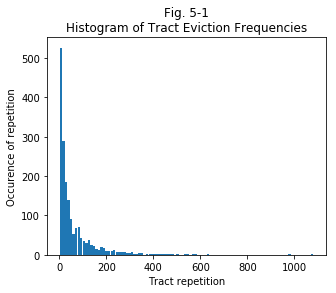

In [20]:
# plotting the tract eviction count repetitions

plt.figure(figsize = (5,4))
plt.title("Fig. 5-1\nHistogram of Tract Eviction Frequencies")
plt.xlabel("Tract repetition")
plt.ylabel("Occurence of repetition")
plt.hist(actual_dict.values(),rwidth = .96,bins = 100)
plt.savefig("f1-tractfreqhist.jpg")
plt.show()

In [21]:
%%time

# seconds
n = 10000

# calculating expected values
expected = np.zeros((6,))
for key in actual_dict.keys():
    expected += np.array(key) * actual_dict[key]

# creating a list to store chi-square values.
chisq = []

# bootstrap a number of times, n
for i in range(n):
    
    # create a numpy array for summing chi-square valuations
    # over the different districts
    obs = np.zeros((6,))
    
    # calculating and summing the random observations
    for key in actual_dict.keys():
        obs += np.random.multinomial(actual_dict[key],key)

    # using the observations to calculate and store the
    # chi-square value.
    chisq.append(sum((expected- obs)**2 / expected))
    


Wall time: 59.1 s


In [22]:
%%time

### 5 seconds

# This sums each row once to get a baseline observation
# and resultant chi-square value.

obs2 = np.zeros(6)
for i,item in t2df.iterrows():
    obs2 += np.array(item["naive"])

chi_base = sum((expected- obs2)**2 / expected)
pval = 1 - ss.chi2.cdf(chi_base,5)
print(pval,chi_base)

0.0 8850.956590428648
Wall time: 4.64 s


In [23]:
%%time

# bootstrap a number of times, n
for i in range(n):
    
    # create a numpy array for summing chi-square valuations
    # over the different districts
    obs = np.zeros((6,))
    
    # calculating and summing the random observations
    for key in actual_dict.keys():
        obs += np.random.multinomial(actual_dict[key],key)

    # using the observations to calculate and store the
    # chi-square value.
    chisq.append(sum((expected- obs)**2 / expected))

Wall time: 59.4 s


In [24]:
# chisq[:10]

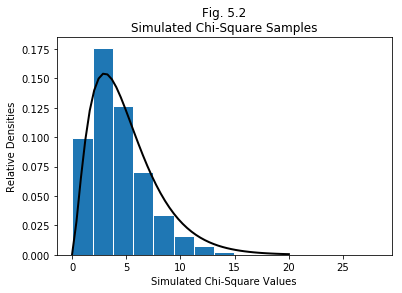

In [25]:
hist = plt.hist(chisq, density=True,edgecolor = "w",bins = 15)
rv = ss.chi2(df = 5)
x = np.linspace(0,20) 
h = plt.plot(x, rv.pdf(x), lw=2,color = "k")

plt.title("Fig. 5.2\nSimulated Chi-Square Samples")
plt.xlabel("Simulated Chi-Square Values")
plt.ylabel("Relative Densities")


plt.savefig("f2-sampledchi.jpg")
plt.show()

In [26]:
pval = 1 - ss.chi2.cdf(chi_base,5)
pval

0.0

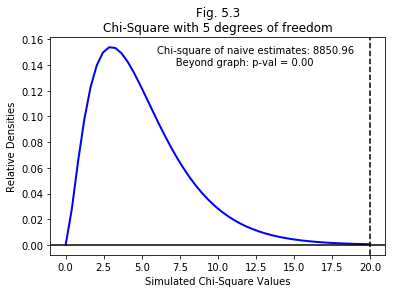

In [27]:

rv = ss.chi2(df = 5)
x = np.linspace(0,20) 
h = plt.plot(x, rv.pdf(x), lw=2,color = "b")

plt.axvline(x = 20,linestyle = "dashed",color = "k")
plt.axhline(y = 0,color = "k")
plt.title("Fig. 5.3\nChi-Square with 5 degrees of freedom")
plt.xlabel("Simulated Chi-Square Values")
plt.ylabel("Relative Densities")

plt.text(6, 
         .14, 
         'Chi-square of naive estimates: {:.2f}\n      Beyond graph: p-val = {:.2f}'.format(chi_base,pval))

plt.savefig("f3-naivepval.jpg")
plt.show()

Now to take the boot_nums and run them through a bootstrap:

In [28]:
df = boot_nums.copy()
# rename = dict(zip(df.columns,[0,1,2]))
# df.rename(columns=rename,inplace = True)

# First real boot strap

In [29]:
# bootstrap for ACROSS TRACTS and EQUAL SAMPLING sampling OBS ONLY
def boot_strap_at_es():
    import pandas as pd
    import numpy as np
    df = boot_nums.copy()
#     rename = dict(zip(df.columns,[0,1,2]))
#     df.rename(columns=rename,inplace = True)

    boot = []
    
    exp = np.zeros(6)
    
    for i,item in df.iterrows():
        exp += np.array(item["loc_scale"])

    for i in range(n):

        obs_temp = np.zeros(6)
        # generate bootstrap distribution
        for i,item in df.iterrows():

            # generate samples from the observed percentages, and sum
            # them over the given district
            obs_temp += np.random.multinomial(1,item["naive"])

        # sampled observed chi-square 
        chi_obs = np.sum((exp - obs_temp)**2 / exp)

        # find the difference in the expectation and the observation
        boot.append(chi_obs)

        # calculate the chi-square summed over all the districts,
        # and store these values in boot2
        
    return boot


In [30]:
# importing the library
import ipyparallel as ipp

# finding the clients
c = ipp.Client()

# assigning them to a view
v = c[:4]

c.ids

[0, 1, 2, 3]

In [31]:
%%time

# distributing the data to our clients
v["boot_nums"] = boot_nums
v["n"] = int(100/len(c.ids))

Wall time: 3.16 s


We lose 3 seconds in start-up overhead distributing the data.

In [32]:
%%time

# 4 minutes-ish

result_list = v.apply_sync(boot_strap_at_es)

results = []

for result in result_list:
    results.extend(result)
    
boot2fast = results

Wall time: 2min 25s


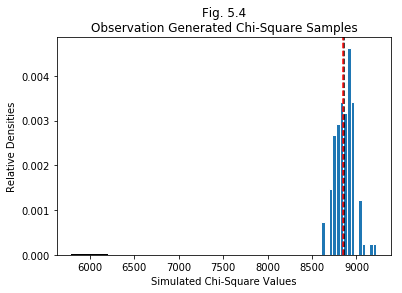

In [52]:
mu = np.mean(boot2fast)
sd = np.std(boot2fast)

hist = plt.hist(boot2fast, density=True,edgecolor = "w",bins = 15)

rv = ss.norm(loc = mu,scale = sd)
x = np.linspace(5800,6200) 
h = plt.plot(x, rv.pdf(x), lw=2,color = "k")

plt.title("Fig. 5.4\nObservation Generated Chi-Square Samples")
plt.xlabel("Simulated Chi-Square Values")
plt.ylabel("Relative Densities")

plt.axvline(x = mu,linestyle = "dashed",color = "k")
plt.axvline(x = chi_base,linestyle = "dashed",color = "r")
plt.savefig("f4-sampledchi.jpg")
plt.show()

In [34]:
np.percentile(boot2fast,[2.5,97.5])

array([8670.88915997, 9054.21302567])

In [35]:
def boot_strap_wt_es_compare():
    import pandas as pd
    import numpy as np
    # df = boot_nums.copy()
    # n = 1
    
    # rename = dict(zip(df.columns,[0,1,2]))
    # df.rename(columns=rename,inplace = True)

    boot = []


    for i in range(n):
        boot_obs = []

        # generate bootstrap distribution
        for name,group in df.groupby("blk_row_num"):

            group = group.reset_index(drop = True)

            # find expectation
            exp = np.array(group["loc_scale"][0]) * group["loc_scale"].size + np.array((.01,.01,.01,.01,.01,.01))

            exp_boot = np.random.multinomial(group["loc_scale"].size,group["loc_scale"][0])

            # generate samples from the observed percentages, and sum
            # them over the given district
            obs_boot = np.sum([np.random.multinomial(1,val) for val in group["naive"]],axis = 0)

            # sampled expected chi-square
            chi_exp = np.sum((exp_boot - exp)**2 / exp)

            # sampled observed chi-square 
            chi_obs = np.sum((exp - obs_boot)**2 / exp)

            # find the difference in the expectation and the observation
            boot_obs.append(chi_obs - chi_exp)

        # calculate the chi-square summed over all the districts,
        # and store these values in boot2
        boot.append(np.sum(boot_obs))
        
    return boot

In [36]:
# importing the library
import ipyparallel as ipp

# finding the clients
c = ipp.Client()

# assigning them to a view
v = c[:4]

c.ids

[0, 1, 2, 3]

In [37]:
%%time

# distributing the data to our clients
v["df"] = boot_nums
v["n"] = int(1000/len(c.ids))

Wall time: 3.17 s


We lose 3 seconds in start-up overhead distributing the data.

In [38]:
%%time

# 4 minutes-ish

result_list = v.apply_sync(boot_strap_wt_es_compare)

results = []

for result in result_list:
    results.extend(result)
    
boot_compare = results

Wall time: 4min 4s


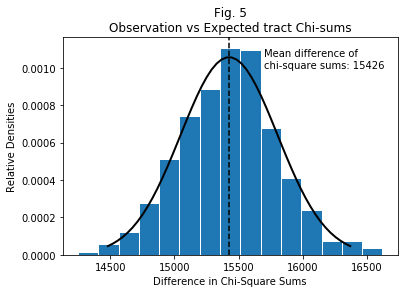

In [53]:
mu = np.mean(boot_compare)
sd = np.std(boot_compare)

hist = plt.hist(boot_compare, density=True,edgecolor = "w",bins = 15)

rv = ss.norm(loc = mu,scale = sd)
x = np.linspace(mu - 2.5*sd,mu + 2.5*sd) 
h = plt.plot(x, rv.pdf(x), lw=2,color = "k")

plt.title("Fig. 5\nObservation vs Expected tract Chi-sums")
plt.xlabel("Difference in Chi-Square Sums")
plt.ylabel("Relative Densities")

plt.axvline(x = mu,linestyle = "dashed",color = "k")
plt.text(mu+275, 
         .0010, 
         'Mean difference of\nchi-square sums: {:.0f}'.format(mu,pval))


plt.savefig("f5-chidiff.jpg")
plt.show()

In [44]:
np.percentile(boot_compare,[1,50,99])

array([14553.77436852, 15431.41136728, 16391.82513565])

Looks like we're nowhere near the origin.  But, it also looks like we have instability in our division.  Because we're frequently dividing by numbers very close to zero, summed chi-square values are egregiously large.  Thankfully, we can cut that out with the bootstrap, and use a variant of this chi-square statistic.  We'll do the subtraction, but not the division by the expectation.

In [45]:
%%time

def boot_strap_chi_no_div():
    import numpy as np
    import pandas as pd
    df = boot_nums.copy()
    rename = dict(zip(df.columns,[0,1,2]))
    df.rename(columns=rename,inplace = True)

    boot = []

    for i in range(n):
        boot_obs = []

        # generate bootstrap distribution
        for name,group in df.groupby(1):

            group = group.reset_index(drop = True)

            # find expectation
            exp = np.array(group[2][0]) * group[2].size

            exp_boot = np.random.multinomial(group[2].size,group[2][0])

            # generate samples from the observed percentages, and sum
            # them over the given district
            obs_boot = np.sum([np.random.multinomial(1,val) for val in group[0]],axis = 0)

            # sampled expected chi-square
            chi_exp = np.sum((exp_boot - exp)**2)

            # sampled observed chi-square 
            chi_obs = np.sum((exp - obs_boot)**2)

            # find the difference in the expectation and the observation
            boot_obs.append(chi_obs - chi_exp)

        # calculate the chi-square summed over all the districts,
        # and store these values in boot2
        boot.append(np.sum(boot_obs))
    return boot

Wall time: 0 ns


In [46]:
%%time

# time = 4min - ish

result_list = v.apply_sync(boot_strap_chi_no_div)

results = []

for result in result_list:
    results.extend(result)
    
boot_no_div = results

Wall time: 3min 51s


In [58]:
35/6

5.833333333333333

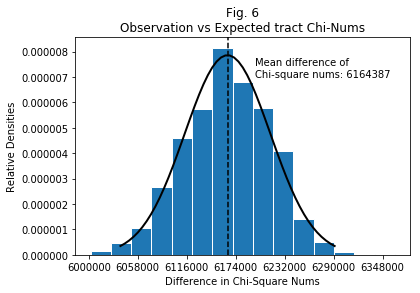

In [61]:
mu = np.mean(boot_no_div)
sd = np.std(boot_no_div)

hist = plt.hist(boot_no_div, density=True,edgecolor = "w",bins = 15)

rv = ss.norm(loc = mu,scale = sd)
x = np.linspace(mu - 2.5*sd,mu + 2.5*sd) 
h = plt.plot(x, rv.pdf(x), lw=2,color = "k")

plt.title("Fig. 6\nObservation vs Expected tract Chi-Nums")
plt.xlabel("Difference in Chi-Square Nums")
plt.ylabel("Relative Densities")
plt.xticks(np.arange(start = 6000000,stop = 6350000,step = 58000))

plt.axvline(x = mu,linestyle = "dashed",color = "k")
plt.text(mu+32500, 
         .000007, 
         'Mean difference of\nChi-square nums: {:.0f}'.format(mu,pval))


plt.savefig("f6-chidiffnodiv.jpg")
plt.show()

In [55]:
mu = np.mean(boot_no_div)
mu

6164386.69393887

In [56]:
sd = np.std(boot_no_div)
sd

50760.18254665739

In [50]:
mu / sd

121.44138150552813

In [51]:
sd

50760.18254665739

Our p-value is miniscule.  There's no way these are coming from the same distribution.

Curiously, the values we calculated, increased by a factor of 3 when we didn't do the division.  Either way, we're really far away.

# A curiosity

Instead of accounting for instability by marginally tweaking the numbers or by not doing the division, let's just find the sample expectations.  This will be muddled if the effects vary in direction over the data, but not if the effect is roughly global.

In [99]:
df = boot_nums.copy()

# iterate over the rows generating our observed chi-square
exp = np.zeros(6)
obs = np.zeros(6)

for i, row in df.iterrows():
    exp += row[0]
    obs += row[2]
    
chi_obs = sum((obs-exp)**2/exp)

In [100]:
# quantile function takes your data, and then the value
# you want to find a quantile for.
np.percentile(chisq,100)

27.870956059017963

In [101]:
chi_obs

5991.786441648933

In [102]:
from scipy.stats import chi2

In [103]:
pval = 1 - chi2.cdf(chi_obs,5)
pval

0.0

# Performing as we've done above, but resampling the probabilities

# What about resampling the probabilities instead of generating predictions?

### resample differences across tracts

In [104]:
# extracting the two probability columns and taking their difference
# must turn them into numpy arrays to get vector subtraction
diffs = df.apply(lambda x: np.array(x["naive"])-np.array(x["loc_scale"]),axis = 1)

In [105]:
# extracting the two probability columns and taking their difference
# must turn them into numpy arrays to get vector subtraction
exps = df.apply(lambda x: np.array(x["naive"]),axis = 1)

In [106]:
# what do we expect to see in our data set?
np.sum(exps)

array([6.36791026e+04, 1.69592831e+04, 1.88021110e+03, 4.24864329e+01,
       2.78228793e+04, 6.85037511e+02])

In [120]:
edict = {}
edict["white"] = 63679
edict["black"] = 16959
edict["api"] = 1880
edict["aian"] = 42
edict["hispanic"] = 27822
edict["multi"] = 685

In [109]:
# name_dict

In [110]:
diffs.size

111069

In [111]:
# the following will randomly sample our rows
test = np.random.choice(diffs.index,size = diffs.size)

In [112]:
# diffs[test]

In [113]:
np.sum(diffs[test],axis = 0)

array([ 8574.43370553, -3470.97902413, -3172.74079992,  -240.27288189,
         723.35588596, -2413.79688554])

In [114]:
def boot_tract_diff():
    import numpy as np
    import pandas as pd
    boot_diff = []
    
    indexes = diffs.index
    how_many = diffs.size
    
    for i in range(n):
        mask = np.random.choice(indexes,size = how_many)
        boot = np.sum(diffs[mask],axis = 0)
        
        boot_diff.append(boot)
    
    return boot_diff

In [115]:
%%time

# time = 1 min - ish

v["diffs"] = diffs

result_list = v.apply_sync(boot_tract_diff)
results = []

for result in result_list:
    results.extend(result)
    
boot_tract_general = results

Wall time: 58.8 s


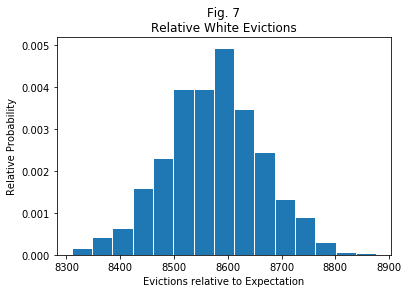

(8572.548985450747, 88.73565600759729)

In [116]:
white = [x[0] for x in boot_tract_general]

fig = plt.figure(figsize = (6,4))
plt.hist(np.array(white),density = True,edgecolor = "w",bins = 15)
plt.title("Fig. 5.7\nRelative Caucasian Evictions")
plt.xlabel("Evictions relative to Expectation")
plt.ylabel("Relative Probability")

plt.savefig("f7-white-evict1.jpg")
plt.show()

mu = np.mean(white)
sd = np.std(white)

mu,sd

In [119]:
np.percentile(white,[2,98])

array([8377.69405246, 8755.29308548])

In [123]:
np.percentile(white,[2,50,98]) / edict["white"]

array([0.13156133, 0.13467331, 0.13749106])

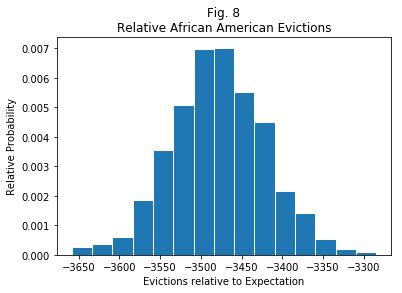

(-3478.2785809109814, 57.89286860847487)

In [124]:
black = [x[1] for x in boot_tract_general]

fig = plt.figure(figsize = (6,4))
plt.hist(np.array(black),density = True,edgecolor = "w",bins = 15)
plt.title("Fig. 5.8\nRelative African American Evictions")
plt.xlabel("Evictions relative to Expectation")
plt.ylabel("Relative Probability")

plt.savefig("f8-black-evict1.jpg")
plt.show()

mu = np.mean(black)
sd = np.std(black)

mu,sd

In [127]:
np.percentile(black,[2.5,50,97.5]) / edict["black"]

array([-0.21181069, -0.20514544, -0.19844811])

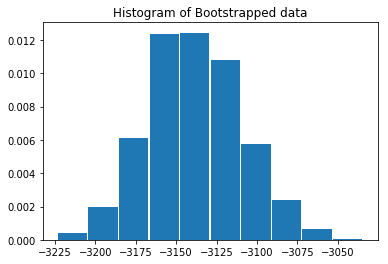

In [128]:
api = [x[2] for x in boot_tract_general]
fig = plt.figure()
plt.hist(np.array(api),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

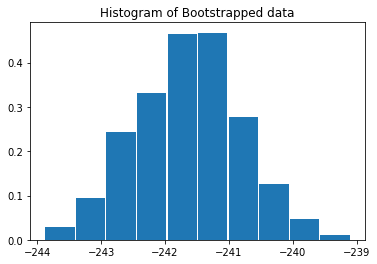

In [129]:
aian = [x[3] for x in boot_tract_general]
fig = plt.figure()
plt.hist(np.array(aian),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

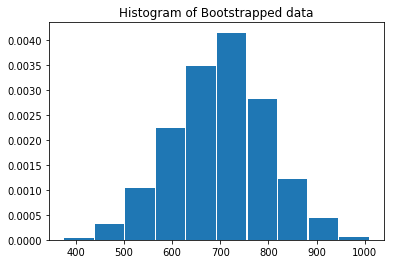

In [130]:
hispanic = [x[4] for x in boot_tract_general]
fig = plt.figure()
plt.hist(np.array(hispanic),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

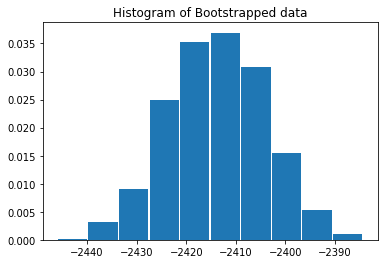

In [131]:
multi = [x[5] for x in boot_tract_general]
fig = plt.figure()
plt.hist(np.array(multi),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

8572.548985450747 88.73565600759729
-3478.2785809109814 57.89286860847487
-3138.70812931802 28.788204530618135
-241.63466073888344 0.814179447448777
699.8447318631902 97.29260344509073
-2413.7723463461084 9.770019973482068


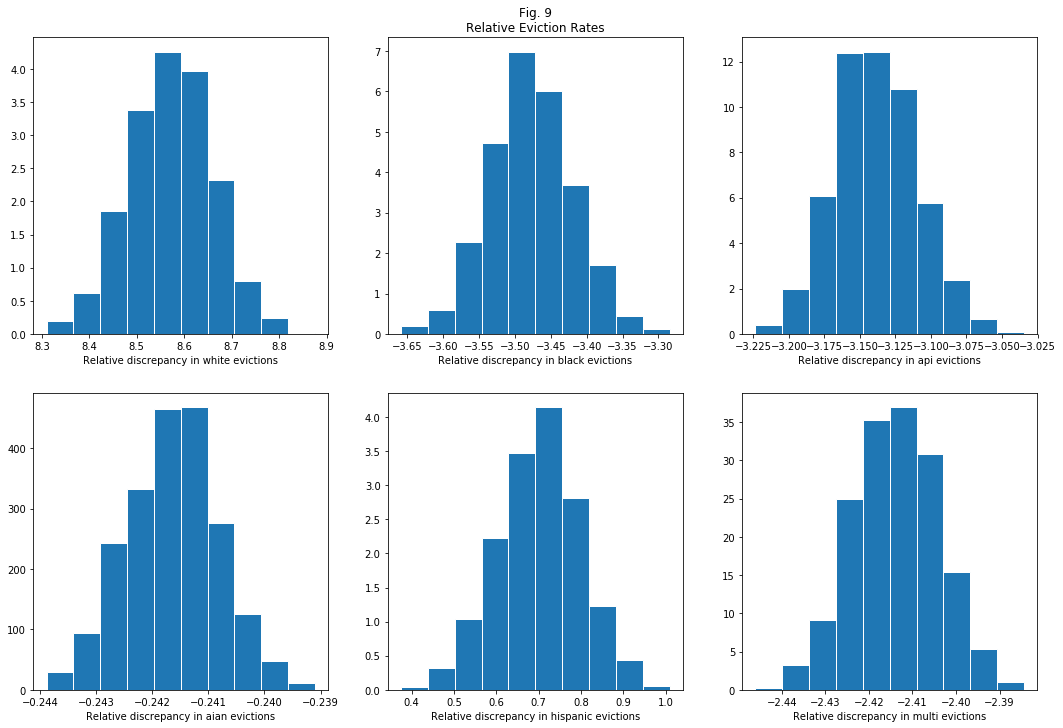

In [133]:
name_dict = dict(zip([0,1,2,3,4,5],["Caucasian","African American","API","AIAN","Hispanic","Multi"]))
ename_dict = name_dict = dict(zip([0,1,2,3,4,5],["white","black","api","aian","hispanic","multi"]))
plt.subplots(nrows = 2,ncols = 3,figsize = (18,12))

ethnic_dict = {}

for i in range(6):

    plt.subplot(2,3,i+1)
    data = np.array([x[i] for x in boot_tract_general])

    ethnic_dict[ename_dict[i]] = np.array([x[i] for x in boot_tract_general])

    plt.hist(data/1000,edgecolor = "w",density = True)
    plt.xlabel("Relative discrepancy in {} evictions".format(name_dict[i]))
    if i == 1:
        plt.title("Fig. 5.9\nRelative Eviction Rates")

    print(np.mean(data),np.std(data))
plt.savefig("f9-Relative eviction panel1.jpg")
plt.show()

In [134]:
data = np.array(boot_tract_general)

In [135]:
mus = np.mean(data,axis = 0)
sd = np.std(data,axis = 0)

mus/sd

array([  96.60771522,  -60.0812961 , -109.02757503, -296.78305132,
          7.19319565, -247.05910048])

In [138]:
np.percentile(ethnic_dict["white"],[2.5])

array([8387.22061889])

In [142]:
for name in ethnic_dict.keys():
    print(name,np.percentile(ethnic_dict[name],[.5,50,99.5])/edict[name])

white [0.13101608 0.13467331 0.13808515]
black [-0.2144324  -0.20514544 -0.1959476 ]
api [-1.70946857 -1.66981266 -1.63005585]
aian [-5.80158058 -5.75251121 -5.70496586]
hispanic [0.01661586 0.0253915  0.03368902]
multi [-3.55828905 -3.52348295 -3.48971727]


### now let's resample according to the right number from each tract.

In [143]:
# i is our block group, and group is the collection of
# cases within that tract.

def boot_tract_specific():
    import numpy as np
    import pandas as pd

    conglomerate = []


    for i, group in df.groupby("blk_row_num"):
        boot_diff = []
        indexes = group.index
        how_many = group.size

        for j in range(n):
            mask = np.random.choice(indexes,size = how_many)
            boot = np.sum(group.loc[mask,"diffs"],axis = 0)

            boot_diff.append(boot)

        conglomerate.append(boot_diff)

    return np.sum(np.array(conglomerate),axis = 0)


In [144]:
df["diffs"] = diffs

In [145]:
%%time

# time - 2 min - ish
v["df"] = df
v["n"] = 100
result_list = v.apply_sync(boot_tract_specific)
results = []

for result in result_list:
    results.extend(result)
    
boot_tract_specific = results

Wall time: 3min 10s


In [146]:
np.array(boot_tract_specific).shape

(400, 6)

51438.82580746899 205.5305140029407
-20878.7692093187 148.3228915962063
-18829.693127548304 64.06767263834587
-1449.8556199844368 0.9587588050282082
4200.544802602153 249.36330082341374
-14481.052653219715 14.299457899542766


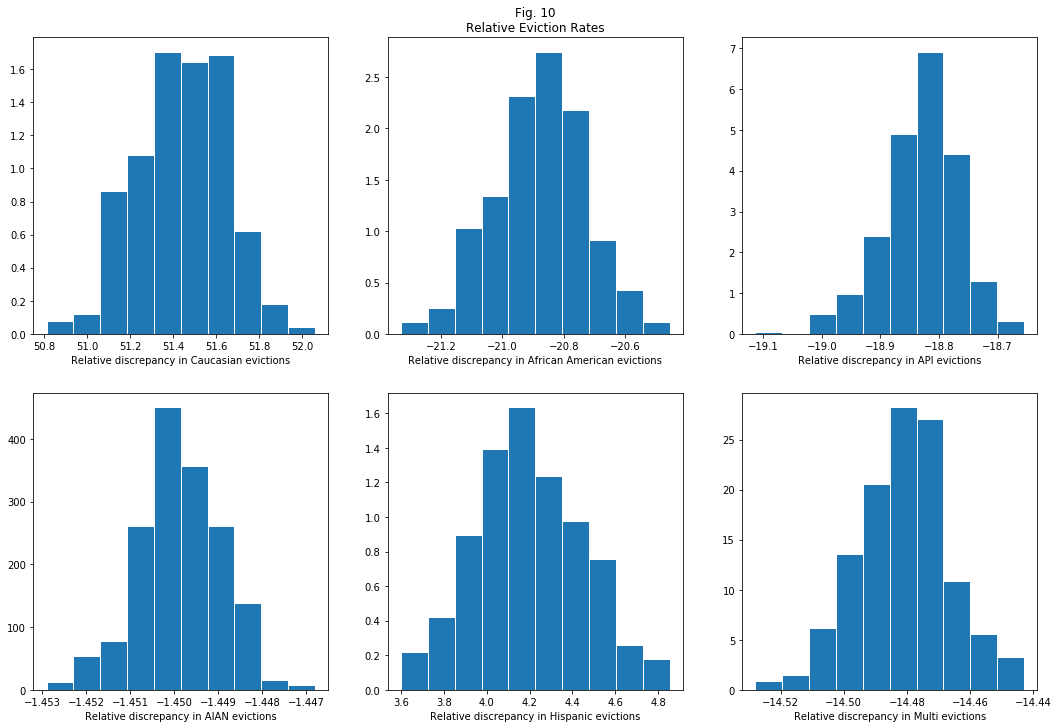

In [147]:
name_dict = dict(zip([0,1,2,3,4,5],["Caucasian","African American","API","AIAN","Hispanic","Multi"]))

plt.subplots(nrows = 2,ncols = 3,figsize = (18,12))

for i in range(6):

    plt.subplot(2,3,i+1)
    data = np.array([x[i] for x in boot_tract_specific])
    plt.hist(data/1000,edgecolor = "w",density = True)
    plt.xlabel("Relative discrepancy in {} evictions".format(name_dict[i]))
    if i == 1:
        plt.title("Fig. 5.10\nRelative Eviction Rates")

    print(np.mean(data),np.std(data))
plt.savefig("f10-Relative eviction panel1s.jpg")
plt.show()

In [148]:
np.round(1.324,1)

1.3

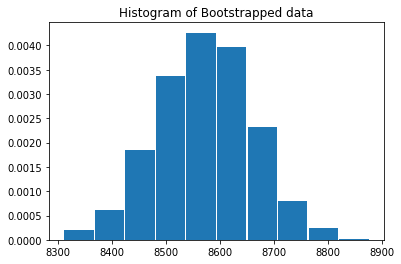

In [149]:
fig = plt.figure()
plt.hist(np.array(white),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

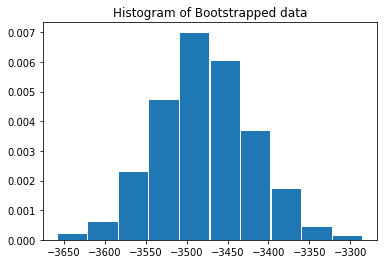

In [150]:
fig = plt.figure()
plt.hist(np.array(black),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

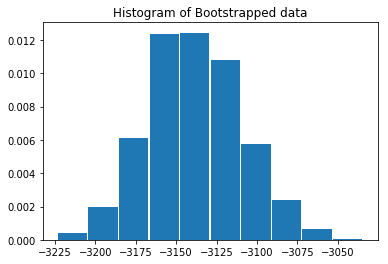

In [151]:
fig = plt.figure()
plt.hist(np.array(api),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

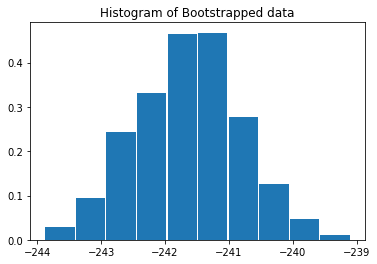

In [152]:
fig = plt.figure()
plt.hist(np.array(aian),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

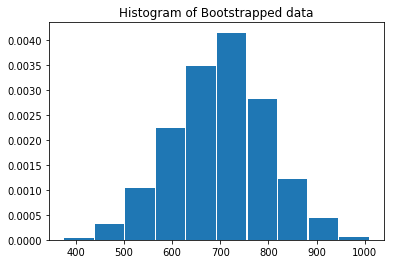

In [153]:
fig = plt.figure()
plt.hist(np.array(hispanic),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

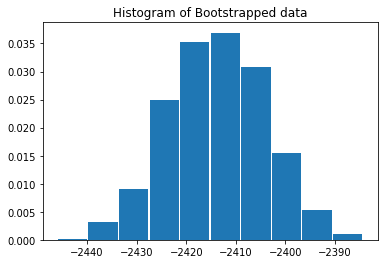

In [154]:
fig = plt.figure()
plt.hist(np.array(multi),density = True,rwidth = .96)
plt.title("Histogram of Bootstrapped data")
plt.show()

# court region

This above gives all the same results.  Some ethnicities are over represented, and other underrepresented.  I think it's time to break this down by court region.

In [155]:
# name_dict = dict(zip([0,1,2,3,4,5],["White","Black","API","AIAN","Hispanic","Multi"]))

# plt.subplots(nrows = 2,ncols = 3,figsize = (30,30))

# for i in range(6):
#     plt.subplot(2,3,i+1)
#     data = np.array([x[i] for x in boot_s_samples])
#     plt.hist(data/1000,rwidth = .96,density = True)
#     plt.title("Relative discrepancy in {} ethnicity\nIn Thousands".format(name_dict[i]))
    
# plt.show()

In [156]:
t2df.groupby("court2").count()

,court,plaintiff,tract,surname,first,blk_row_num,pop,loc,loc_scale,sur,naive
court2,,,,,,,,,,,
Central Housing Court,36706,36706,36706,36706,36706,36706,36706,36706,36706,36706,36706
Eastern Housing Court,35986,35986,35986,35986,35986,35986,35986,35986,35986,35986,35986
Northeast Housing Court,56,56,56,56,56,56,56,56,56,56,56
Western Housing Court,35547,35547,35547,35547,35547,35547,35547,35547,35547,35547,35547


In [157]:
if test == 42:
    with open("court_examine.pickle","wb") as f:
        t2df.to_pickle(f)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# New continuation point
<a class="anchor" id="pick-up-2"></a>

In [158]:
# This function boot-straps with equal emphasis on each data point.
def boot_strap_fast(df,source = "loc_scale",model = "naive",n = 1000):
    """This function boot-straps with equal emphasis on every
    data point in the data-frame.  The boot-strap samples are the
    difference between observed and expected counts."""
    
#     import numpy as np
#     import pandas as pd
  
#     df = boot_nums.copy()
#     rename = dict(zip(df.columns,[0,1,2]))
#     df.rename(columns=rename,inplace = True)

    boot = []

    exp = np.zeros(6)
    obs = np.zeros(6)
    
    group = []
    
    for i, row in df.iterrows():

        exp += np.array(row[source])
        group.append(np.random.multinomial(1,row[model],size = n))

    data = np.array(group)
    compress = np.sum(data,axis = 0) - exp
    return compress

In [159]:
with open("court_examine.pickle","rb") as f:
    t2df = pd.read_pickle(f)

In [160]:
c = ipp.Client()
v = c[:]

# We want to bootstrap on the eastern housing court

In [161]:
court = t2df.drop(columns = ["plaintiff","tract","surname","first","pop","loc","sur","court"])
court.head()

,blk_row_num,loc_scale,court2,sur_pop,naive
0,90982,"[0.9245810055865922, 0.0111731843575419, 0.022...",Western Housing Court,0.000237,"[0.9991637260520293, 0.00018981061803760812, 0..."
1,92282,"[0.5084635416666666, 0.01953125, 0.00716145833...",Western Housing Court,0.000857,"[0.071180436152208, 0.00038140992698220967, 0...."
2,92282,"[0.5084635416666666, 0.01953125, 0.00716145833...",Western Housing Court,0.000047,"[0.057398096572507926, 0.00017326463198159004,..."
3,92318,"[0.7836477987421384, 0.029559748427672956, 0.0...",Western Housing Court,0.000315,"[0.19316592466272808, 0.0005385566815741495, 8..."
4,92282,"[0.5084635416666666, 0.01953125, 0.00716145833...",Western Housing Court,0.000001,"[0.9852639753429308, 0.0005989826752142546, 6...."


In [162]:
# sdf = court[court["court"] == "Summary Process"]
edf = court[court["court2"] == "Eastern Housing Court"]

In [163]:
%%time

# time - 2-3 min - ish

# v["boot_nums"] = sdf.loc[:,["loc_scale","blk_row_num","naive"]]
# v["n"] = int(1000/len(c.ids))

# result_list = v.apply_sync(boot_strap)

# results = []

# for result in result_list:
#     results.extend(result)
    
# boot_s_no_div = results

boot_s_no_div = boot_strap_fast(edf)


Wall time: 6.49 s


In [164]:
boot_s_no_div

array([[ 3856.75980723,  -767.88377258, -1468.29696438,   -81.72070195,
         -330.77152967, -1208.08683866],
       [ 3819.75980723,  -761.88377258, -1431.29696438,   -77.72070195,
         -347.77152967, -1201.08683866],
       [ 3729.75980723,  -672.88377258, -1477.29696438,   -83.72070195,
         -308.77152967, -1187.08683866],
       ...,
       [ 3797.75980723,  -775.88377258, -1472.29696438,   -83.72070195,
         -268.77152967, -1197.08683866],
       [ 3871.75980723,  -736.88377258, -1490.29696438,   -75.72070195,
         -358.77152967, -1210.08683866],
       [ 3772.75980723,  -701.88377258, -1488.29696438,   -79.72070195,
         -292.77152967, -1210.08683866]])

In [173]:
edict
ndict = {}
ndict = dict(zip([0,1,2,3,4,5],edict.values()))

In [212]:
ndict

{0: 63679, 1: 16959, 2: 1880, 3: 42, 4: 27822, 5: 685}

99percentiles =  [3685.70980723 3828.75980723 3980.77980723]
relative rates =  [0.05787952 0.06012594 0.06251323] 

99percentiles =  [-897.89377258 -764.88377258 -611.88377258]
relative rates =  [-0.05294497 -0.04510194 -0.03608018] 

99percentiles =  [-1521.29696438 -1455.29696438 -1391.29696438]
relative rates =  [-0.80920051 -0.77409413 -0.74005158] 

99percentiles =  [-91.72070195 -81.72070195 -70.71570195]
relative rates =  [-2.18382624 -1.945731   -1.68370719] 

99percentiles =  [-422.77652967 -318.77152967 -210.77152967]
relative rates =  [-0.01519576 -0.01145753 -0.00757571] 

99percentiles =  [-1256.08683866 -1209.08683866 -1158.08183866]
relative rates =  [-1.83370341 -1.76509028 -1.69063042] 



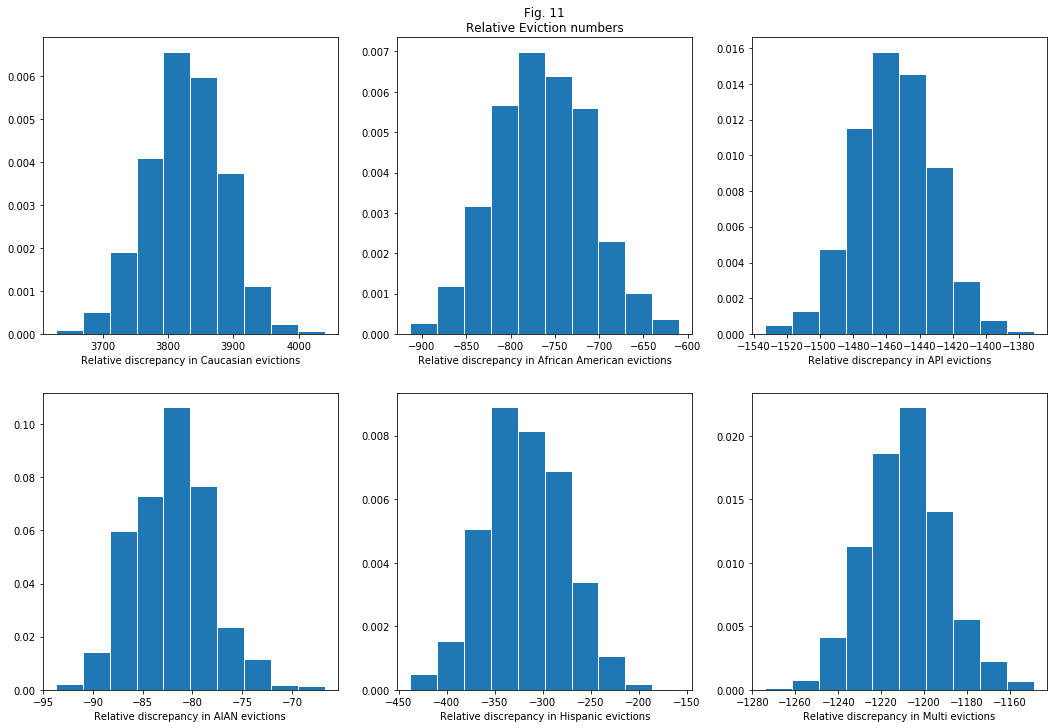

In [175]:
edf = court[court["court2"] == "Eastern Housing Court"]
boot_s = boot_strap_fast(edf)

name_dict = dict(zip([0,1,2,3,4,5],["Caucasian","African American","API","AIAN","Hispanic","Multi"]))

plt.subplots(nrows = 2,ncols = 3,figsize = (18,12))

for i in range(6):

    plt.subplot(2,3,i+1)
    data = np.array([x[i] for x in boot_s])
    plt.hist(data,edgecolor = "w",density = True)
    plt.xlabel("Relative discrepancy in {} evictions".format(name_dict[i]))
    if i == 1:
        plt.title("Fig. 5.11\nRelative Eviction numbers")

    print("99percentiles = ",np.percentile(data,[.5,50,99.5]))
    print("relative rates = ",np.percentile(data,[.5,50,99.5])/ndict[i],"\n")
        
plt.savefig("f11-Relative eviction panel-ce.jpg")
plt.show()

In [176]:
edict

{'white': 63679,
 'black': 16959,
 'api': 1880,
 'aian': 42,
 'hispanic': 27822,
 'multi': 685}

In [177]:
boot_s

array([[ 3795.75980723,  -721.88377258, -1447.29696438,   -80.72070195,
         -361.77152967, -1184.08683866],
       [ 3833.75980723,  -806.88377258, -1470.29696438,   -83.72070195,
         -295.77152967, -1177.08683866],
       [ 3855.75980723,  -874.88377258, -1458.29696438,   -78.72070195,
         -255.77152967, -1188.08683866],
       ...,
       [ 3835.75980723,  -780.88377258, -1464.29696438,   -81.72070195,
         -307.77152967, -1201.08683866],
       [ 3842.75980723,  -751.88377258, -1444.29696438,   -85.72070195,
         -356.77152967, -1204.08683866],
       [ 3747.75980723,  -701.88377258, -1432.29696438,   -82.72070195,
         -323.77152967, -1207.08683866]])

In [166]:
pval = 1 - ss.norm.cdf(0,-81.81470194565482, 3.8206235093241)
pval

0.0

In the eastern district, we see everyone is underevicted except for Caucasian citizens.  While some of these numbers are in fact close to zero, the lower variance for the values with smaller magnitude keeps these numbers from ever actually being zero.

This is not what we expected to see.

99percentiles =  [2479.65327551 2610.66327551 2744.68827551]
relative rates =  [0.03893989 0.04099724 0.04310194] 

99percentiles =  [-1126.64642884 -1049.14142884  -968.63642884]
relative rates =  [-0.06643354 -0.0618634  -0.05711636] 

99percentiles =  [-1057.94371486 -1009.94371486  -961.93871486]
relative rates =  [-0.56273602 -0.5372041  -0.51166953] 

99percentiles =  [-91.93269638 -82.93269638 -71.92769638]
relative rates =  [-2.18887372 -1.97458801 -1.7125642 ] 

99percentiles =  [ 59.71946707 154.73946707 266.74946707]
relative rates =  [0.00214648 0.00556177 0.00958772] 

99percentiles =  [-653.88990251 -622.88490251 -590.88490251]
relative rates =  [-0.9545838  -0.90932103 -0.8626057 ] 



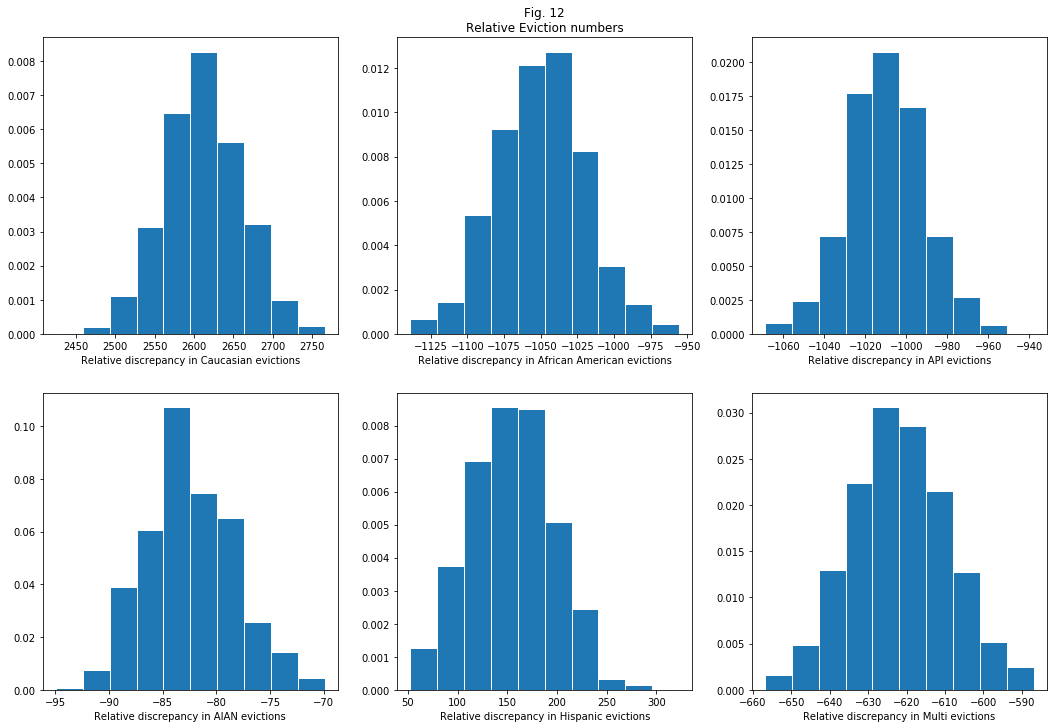

In [179]:
cdf = court[court["court2"] == "Central Housing Court"]
boot_s = boot_strap_fast(cdf)

name_dict = dict(zip([0,1,2,3,4,5],["Caucasian","African American","API","AIAN","Hispanic","Multi"]))

plt.subplots(nrows = 2,ncols = 3,figsize = (18,12))

for i in range(6):

    plt.subplot(2,3,i+1)
    data = np.array([x[i] for x in boot_s])
    plt.hist(data,edgecolor = "w",density = True)
    plt.xlabel("Relative discrepancy in {} evictions".format(name_dict[i]))
    if i == 1:
        plt.title("Fig. 5.12\nRelative Eviction numbers")

    print("99percentiles = ",np.percentile(data,[.5,50,99.5]))
    print("relative rates = ",np.percentile(data,[.5,50,99.5])/ndict[i],"\n")
        
plt.savefig("f12-Relative eviction panel-cc.jpg")
plt.show()

99percentiles =  [1645.36280397 1766.37280397 1887.39780397]
relative rates =  [0.02583839 0.0277387  0.02963925] 

99percentiles =  [-1698.74147226 -1595.74147226 -1489.71647226]
relative rates =  [-0.10016755 -0.09409408 -0.08784224] 

99percentiles =  [-572.10303341 -546.10303341 -513.10303341]
relative rates =  [-0.30431012 -0.29048034 -0.27292715] 

99percentiles =  [-75.9647277 -69.9597277 -60.9597277]
relative rates =  [-1.80868399 -1.6657078  -1.45142209] 

99percentiles =  [ 793.79757203  905.80757203 1016.80757203]
relative rates =  [0.02853129 0.03255724 0.03654689] 

99percentiles =  [-481.38114264 -459.37614264 -434.37114264]
relative rates =  [-0.70274619 -0.67062211 -0.63411846] 



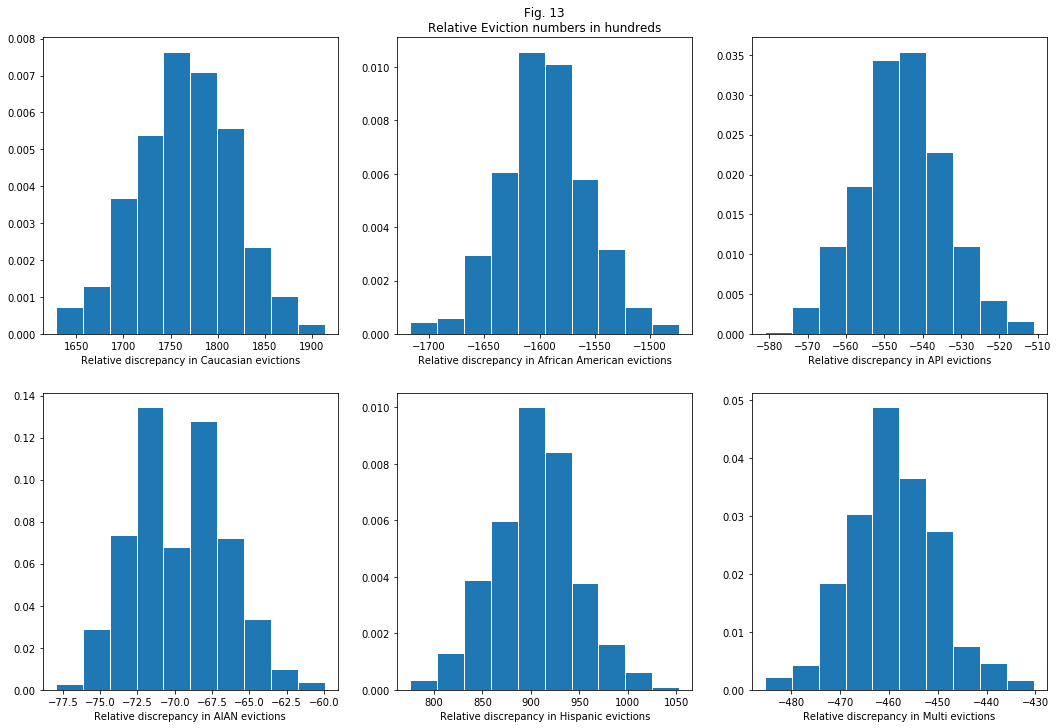

In [180]:
wdf = court[court["court2"] == "Western Housing Court"]
boot_s = boot_strap_fast(wdf)


name_dict = dict(zip([0,1,2,3,4,5],["Caucasian","African American","API","AIAN","Hispanic","Multi"]))

plt.subplots(nrows = 2,ncols = 3,figsize = (18,12))

for i in range(6):

    plt.subplot(2,3,i+1)
    data = np.array([x[i] for x in boot_s])
    plt.hist(data,edgecolor = "w",density = True)
    plt.xlabel("Relative discrepancy in {} evictions".format(name_dict[i]))
    if i == 1:
        plt.title("Fig. 5.13\nRelative Eviction numbers in hundreds")

    print("99percentiles = ",np.percentile(data,[.5,50,99.5]))
    print("relative rates = ",np.percentile(data,[.5,50,99.5])/ndict[i],"\n")
        
plt.savefig("f13-Relative eviction panel-cw.jpg")
plt.show()

In [181]:
def boot_strap_local(df,n = 1000, baseline = "loc_scale",model = "naive"):
    """Slightly more robust variation of the fast boot strap.
    This variation won't crash if the last value
    in a probability profile is zero."""
    
    boot = []

    exp = np.zeros(6)
    obs = np.zeros(6)
    
    group = []
    
    for i, row in df.iterrows():

        exp += np.array(row[baseline])
        
        try:
            generate = np.random.multinomial(1,row[model],size = n)
            group.append(generate)
        except:
            attempt = np.random.multinomial(1,row[model][:-1],size = n)
            temp = np.zeros(shape = (n,6))
            temp[:,:-1] = attempt
            group.append(temp)

    data = np.array(group)
    compress = np.sum(data,axis = 0) - np.array(exp)
    return compress

In [182]:
wdf.head()

,blk_row_num,loc_scale,court2,sur_pop,naive
0,90982,"[0.9245810055865922, 0.0111731843575419, 0.022...",Western Housing Court,0.000237,"[0.9991637260520293, 0.00018981061803760812, 0..."
1,92282,"[0.5084635416666666, 0.01953125, 0.00716145833...",Western Housing Court,0.000857,"[0.071180436152208, 0.00038140992698220967, 0...."
2,92282,"[0.5084635416666666, 0.01953125, 0.00716145833...",Western Housing Court,0.000047,"[0.057398096572507926, 0.00017326463198159004,..."
3,92318,"[0.7836477987421384, 0.029559748427672956, 0.0...",Western Housing Court,0.000315,"[0.19316592466272808, 0.0005385566815741495, 8..."
4,92282,"[0.5084635416666666, 0.01953125, 0.00716145833...",Western Housing Court,0.000001,"[0.9852639753429308, 0.0005989826752142546, 6...."


# Restoring zips to our dataframe

In [183]:
import pickle

In [184]:
with open("metro_zips.pickle","rb") as f:
    metro_zips = pickle.load(f)

In [185]:
with open("addresses.pickle","rb") as f:
    already_seen = pickle.load(f)

In [186]:
block_to_zip = dict()

for key,val in already_seen.items():
    if val != None:
        block_to_zip[tuple(val)] = key[1]

In [187]:
t2df["zips"] = t2df.apply(lambda x:block_to_zip[tuple(x["tract"])],axis = 1)

In [188]:
t2df["metro"] = t2df.apply(lambda x: True if x["zips"] in metro_zips else None,axis = 1)

In [189]:
mdf = t2df.drop(columns = ["metro"]).dropna()

In [193]:
def panel_plot(data,number,title,savename):
    
    name_dict = dict(zip([0,1,2,3,4,5],["Caucasian","African American","API","AIAN","Hispanic","Multi"]))

    plt.subplots(nrows = 2,ncols = 3,figsize = (18,12))

    for i in range(6):

        plt.subplot(2,3,i+1)
        data = np.array([x[i] for x in boot_s])
        plt.hist(data,edgecolor = "w",density = True)
        plt.xlabel("Relative discrepancy in {} evictions".format(name_dict[i]))
        if i == 1:
            plt.title("Fig. 5.{}\n{}".format(number,title))

        print("99percentiles = ",np.percentile(data,[.5,50,99.5]))
        print("relative rates = ",np.percentile(data,[.5,50,99.5])/ndict[i],"\n")
        
    plt.savefig("f{}-{}.jpg".format(number,savename))
    plt.show()

99percentiles =  [7989.12750954 8207.13250954 8456.21750954]
relative rates =  [0.12545937 0.12888287 0.13279445] 

99percentiles =  [-3606.37721645 -3411.35721645 -3236.32721645]
relative rates =  [-0.2126527  -0.20115321 -0.19083243] 

99percentiles =  [-3095.88492448 -3012.87992448 -2932.86992448]
relative rates =  [-1.6467473  -1.6025957  -1.56003719] 

99percentiles =  [-251.71679664 -234.71679664 -216.71179664]
relative rates =  [-5.99325706 -5.58849516 -5.15980468] 

99percentiles =  [552.91644924 743.95144924 941.96644924]
relative rates =  [0.01987335 0.02673968 0.03385689] 

99percentiles =  [-2356.14502119 -2292.13002119 -2232.13002119]
relative rates =  [-3.43962777 -3.34617521 -3.25858397] 



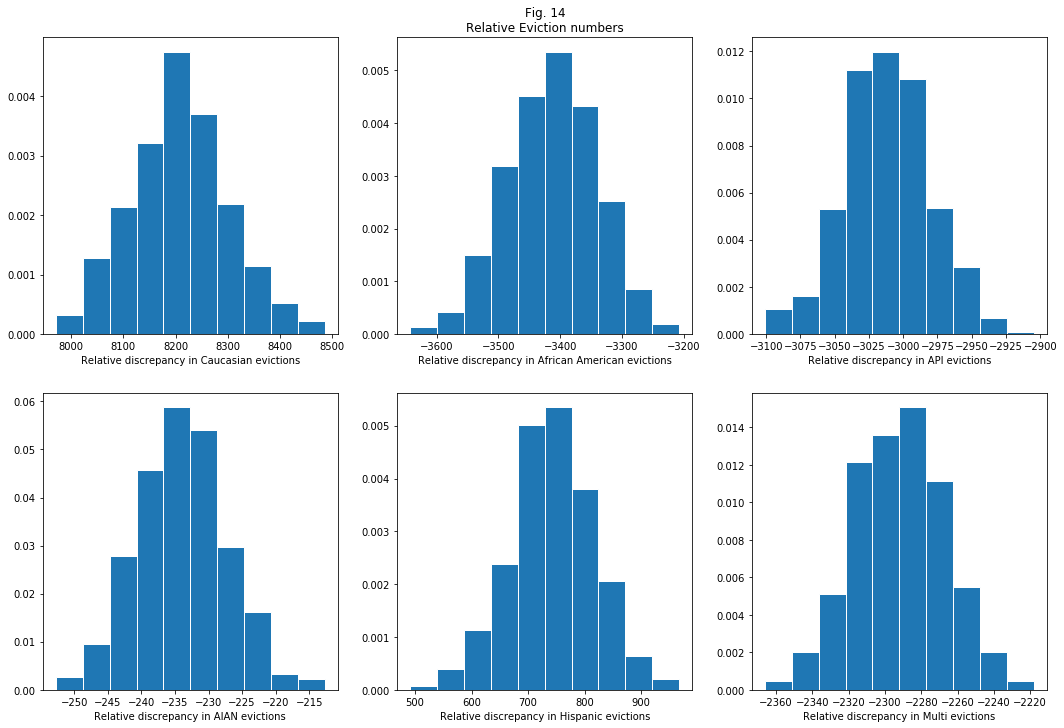

Wall time: 26.7 s


In [194]:
%%time

# time - 12 seconds

boot_s = boot_strap_local(mdf)

panel_plot(boot_s, 14,"Relative Eviction numbers","Relative eviction panel-cm")

In [195]:
t2df.head()

,court,plaintiff,tract,surname,first,blk_row_num,pop,loc,loc_scale,sur,court2,sur_pop,naive,zips,metro
0,Summary Process,"Spruces MHC, LLc","[25, 920101, 4]",hartman,donna,90982,716,"(662, 8, 16, 1, 20, 9)","[0.9245810055865922, 0.0111731843575419, 0.022...","[0.9542, 0.015, 0.0044, 0.0038, 0.012, 0.0105]",Western Housing Court,0.000237,"[0.9991637260520293, 0.00018981061803760812, 0...",01267,None
1,Western Housing Court,Holyoke Hsg Authority,"[25, 812002, 1]",cruz,sarah,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.059500000000000004, 0.0083, 0.0561000000000...",Western Housing Court,0.000857,"[0.071180436152208, 0.00038140992698220967, 0....",01040,None
2,Western Housing Court,H.h.a.,"[25, 812002, 1]",heredia,zusette,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.0509, 0.004, 0.0076, 0.0040999999999999995,...",Western Housing Court,0.000047,"[0.057398096572507926, 0.00017326463198159004,...",01040,None
3,Western Housing Court,Powdermill Village Apts.,"[25, 812500, 3]",vazquez,luz,92318,1590,"(1246, 47, 14, 0, 253, 30)","[0.7836477987421384, 0.029559748427672956, 0.0...","[0.046, 0.0034000000000000002, 0.0019, 0.0009,...",Western Housing Court,0.000315,"[0.19316592466272808, 0.0005385566815741495, 8...",01085,None
4,Western Housing Court,H.h.a.,"[25, 812002, 1]",lundrigan,victoria,92282,1536,"(781, 30, 11, 3, 702, 9)","[0.5084635416666666, 0.01953125, 0.00716145833...","[0.9604, 0.0152, 0.004599999999999993, 0.0, 0....",Western Housing Court,0.000001,"[0.9852639753429308, 0.0005989826752142546, 6....",01040,None


# Plaintiffs?

Maybe it's possible that a low rate or high rate plaintiff is likely to disenfranchise?

In [196]:
test = t2df[["plaintiff","court"]].groupby(["plaintiff"]).count()

In [197]:
# for name in test.index:
#     print(name)

In [198]:
def parse(string):
    string = string.lower()
    new = []
    for char in string:
        if char in ", .":
            pass
        else:
            new.append(char)
            
    return "".join(new)[:7]

In [199]:
t2df["newp"] = t2df.apply(lambda x: parse(x["plaintiff"]),axis = 1)

In [200]:
vals = t2df.groupby("newp").count()["court"]

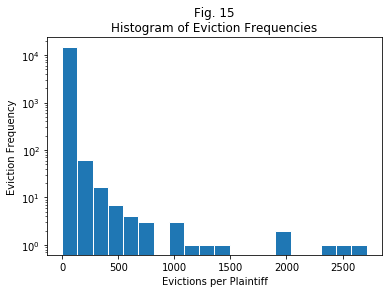

In [203]:
plt.hist(vals,bins = 20,edgecolor = "w")
plt.title("Fig. 5.15\nHistogram of Eviction Frequencies")
plt.xlabel("Evictions per Plaintiff")
plt.ylabel("Eviction Frequency")
plt.yscale('log')
plt.savefig("f15-plaintiff eviction histogram.jpg")
plt.show()

In [204]:
np.percentile(vals,[50,75,90,95,99])

array([ 2.,  4.,  9., 19., 96.])

In [205]:
def categorize(name):
    num= vals[name]
    if num < 10:
        return 1
    elif num < 20:
        return 2
    elif num < 97:
        return 3
    else:
        return 4

In [206]:
t2df["cat"] = t2df.apply(lambda x: categorize(x["newp"]),axis = 1)

In [207]:
onedf = t2df[t2df["cat"]==1]
twodf = t2df[t2df["cat"]==2]
threedf = t2df[t2df["cat"]==3]
fourdf = t2df[t2df["cat"]==4]

99percentiles =  [3114.37317474 3239.38317474 3365.38817474]
relative rates =  [0.04890738 0.05087051 0.05284926] 

99percentiles =  [-882.20906718 -782.19406718 -689.16406718]
relative rates =  [-0.05202011 -0.04612265 -0.04063707] 

99percentiles =  [-905.16748451 -865.16748451 -826.16248451]
relative rates =  [-0.48147207 -0.46019547 -0.43944813] 

99percentiles =  [-71.7203783 -64.7203783 -55.7203783]
relative rates =  [-1.70762805 -1.54096139 -1.32667567] 

99percentiles =  [-915.1786893 -819.1786893 -724.1636893]
relative rates =  [-0.03289407 -0.02944356 -0.02602846] 

99percentiles =  [-746.13255546 -708.12255546 -670.12255546]
relative rates =  [-1.08924461 -1.03375556 -0.9782811 ] 



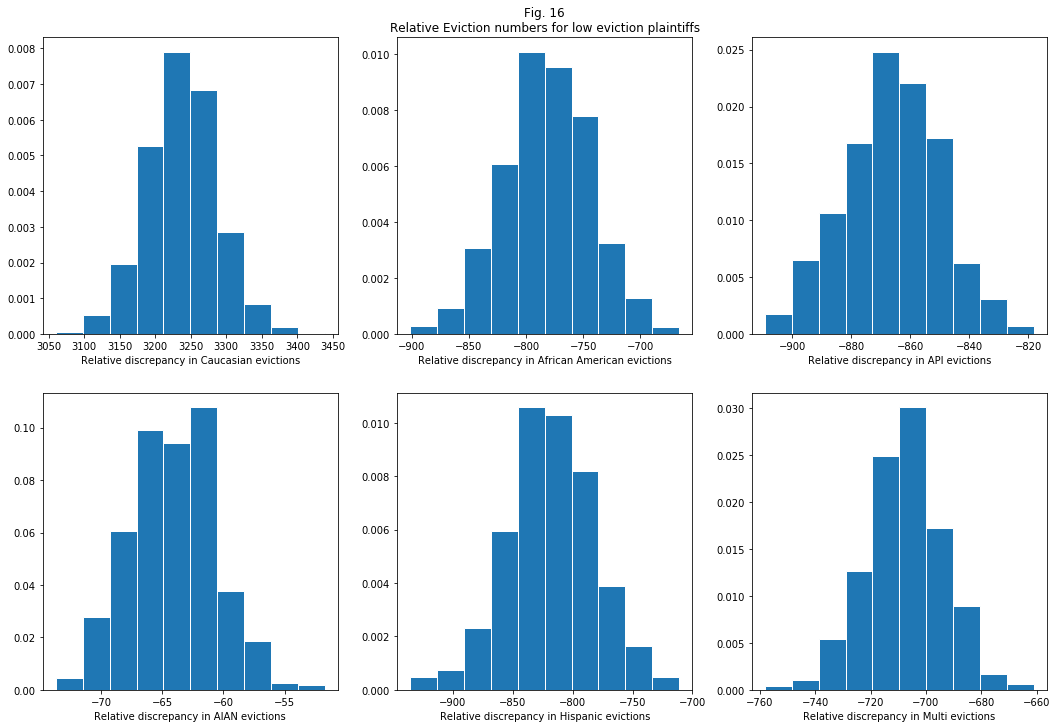

Wall time: 5.34 s


In [208]:
%%time

boot_s = boot_strap_local(onedf)

panel_plot(boot_s, 16,"Relative Eviction numbers for low eviction plaintiffs","Relative eviction panel-p1")

99percentiles =  [772.95378495 833.96378495 898.96878495]
relative rates =  [0.01213828 0.01309637 0.01411719] 

99percentiles =  [-315.78278379 -268.77778379 -215.76278379]
relative rates =  [-0.01862037 -0.01584868 -0.01272261] 

99percentiles =  [-283.08066756 -260.08066756 -235.07566756]
relative rates =  [-0.15057482 -0.13834078 -0.12504025] 

99percentiles =  [-21.50019556 -18.50019556 -12.50019556]
relative rates =  [-0.51190942 -0.44048085 -0.2976237 ] 

99percentiles =  [-160.35205521 -105.35205521  -54.33205521]
relative rates =  [-0.0057635  -0.00378665 -0.00195285] 

99percentiles =  [-199.25308283 -182.25308283 -160.25308283]
relative rates =  [-0.29088041 -0.26606289 -0.23394611] 



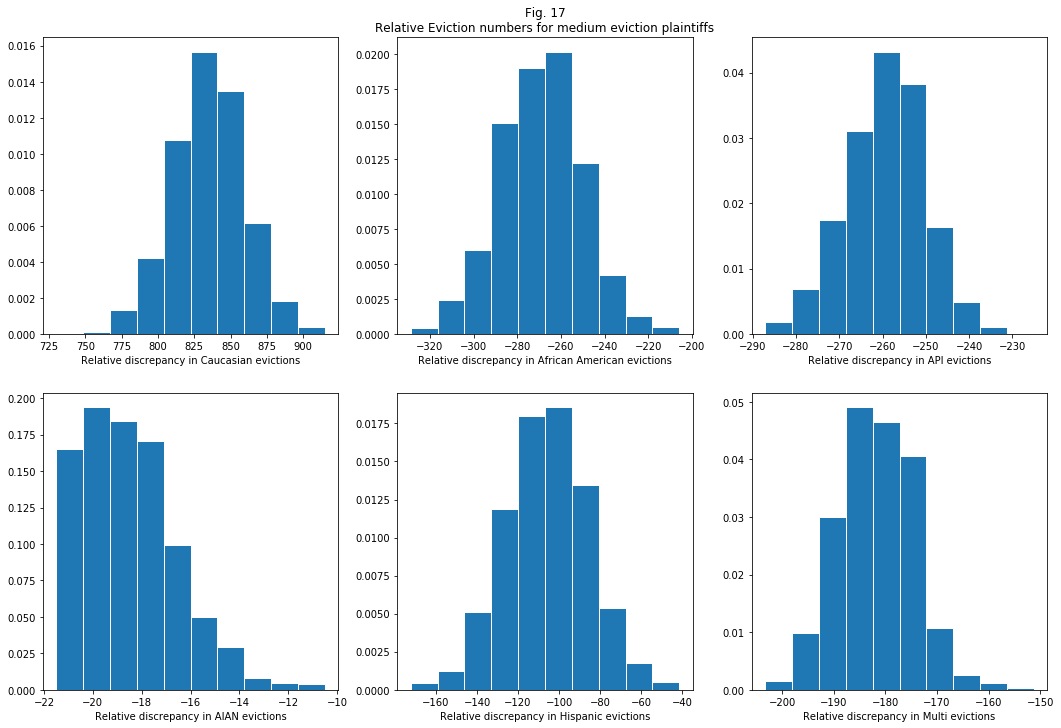

Wall time: 1.84 s


In [209]:
%%time

boot_s = boot_strap_local(twodf)

panel_plot(boot_s, 17,"Relative Eviction numbers for medium eviction plaintiffs","Relative eviction panel-p2")

99percentiles =  [1567.88657887 1676.90157887 1781.91657887]
relative rates =  [0.02462172 0.02633367 0.0279828 ] 

99percentiles =  [-748.75418503 -667.24418503 -588.72418503]
relative rates =  [-0.04415085 -0.03934455 -0.03471456] 

99percentiles =  [-658.38433726 -619.38433726 -578.38433726]
relative rates =  [-0.35020443 -0.32945975 -0.30765124] 

99percentiles =  [-55.71652501 -48.71652501 -41.70652501]
relative rates =  [-1.32658393 -1.15991726 -0.9930125 ] 

99percentiles =  [ 47.24686953 130.25686953 219.26186953]
relative rates =  [0.00169818 0.00468179 0.00788088] 

99percentiles =  [-495.32340111 -471.31340111 -442.31340111]
relative rates =  [-0.72309986 -0.68804876 -0.64571299] 



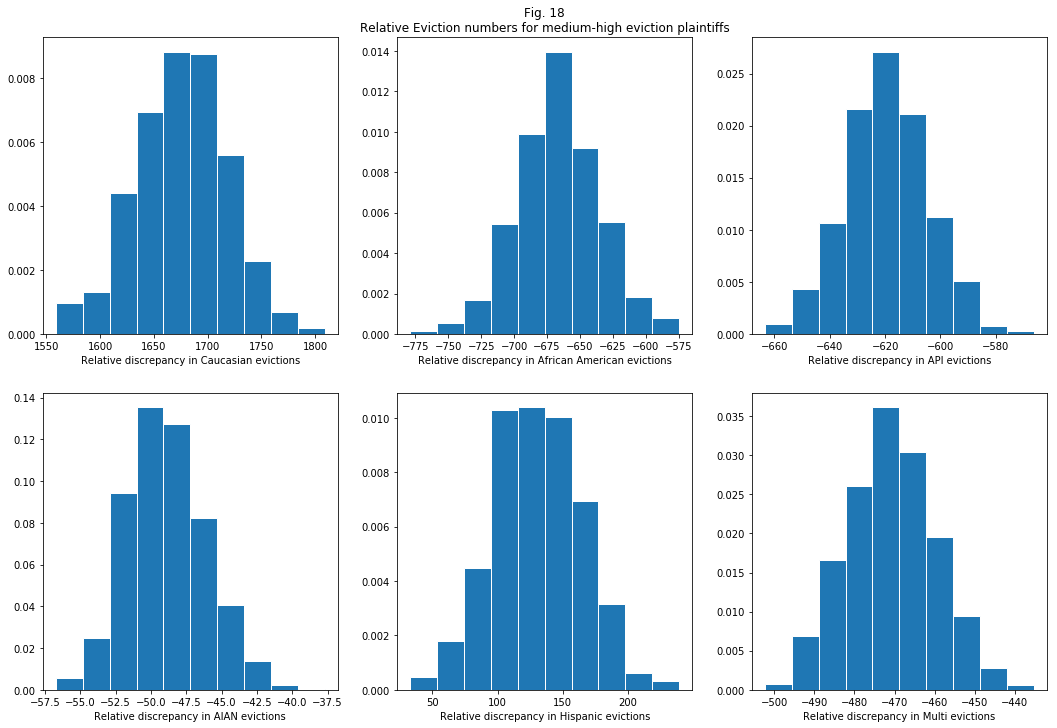

Wall time: 4.46 s


In [210]:
%%time

boot_s = boot_strap_local(threedf)

panel_plot(boot_s, 18,"Relative Eviction numbers for medium-high eviction plaintiffs","Relative eviction panel-p3")

99percentiles =  [2661.84727495 2822.94727495 2987.94727495]
relative rates =  [0.04180102 0.0443309  0.04692202] 

99percentiles =  [-1906.78176922 -1762.78176922 -1627.74176922]
relative rates =  [-0.1124348  -0.10394373 -0.095981  ] 

99percentiles =  [-1446.96835861 -1392.96335861 -1339.95335861]
relative rates =  [-0.76966402 -0.74093796 -0.71274115] 

99percentiles =  [-120.17547951 -110.17547951  -99.17047951]
relative rates =  [-2.86132094 -2.6232257  -2.36120189] 

99percentiles =  [1350.75582052 1498.77082052 1628.78082052]
relative rates =  [0.04854992 0.05386999 0.05854291] 

99percentiles =  [-1094.79748813 -1053.79748813 -1011.78748813]
relative rates =  [-1.59824451 -1.53839049 -1.47706203] 



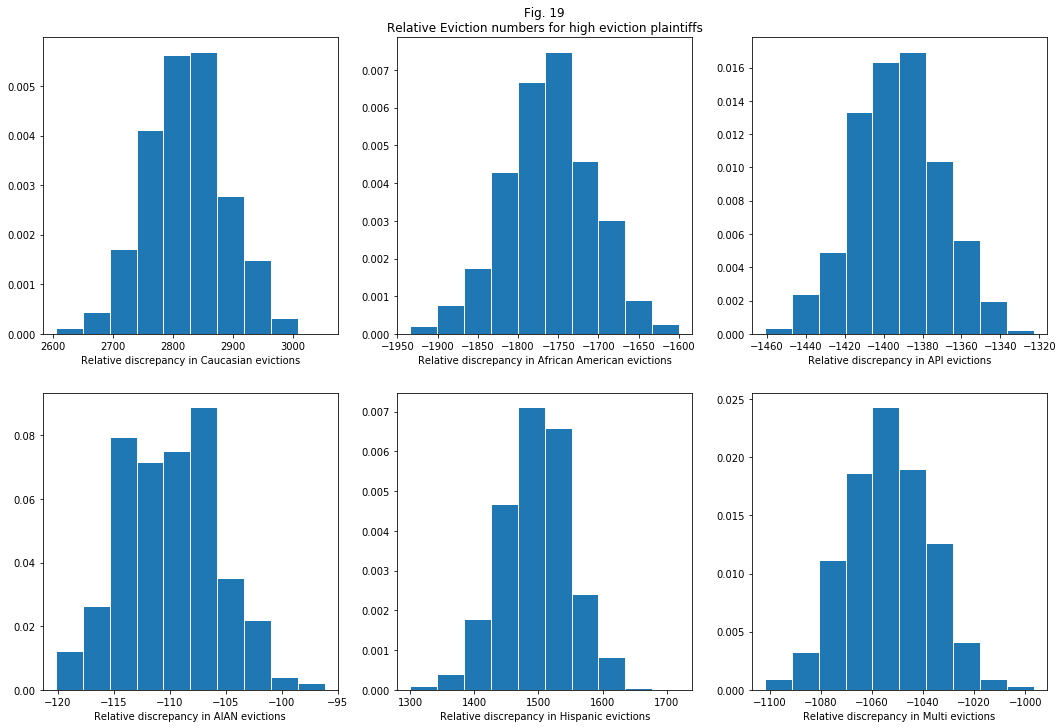

Wall time: 10.3 s


In [211]:
%%time

boot_s = boot_strap_local(fourdf)

panel_plot(boot_s, 19,"Relative Eviction numbers for high eviction plaintiffs","Relative eviction panel-p4")

# !Follow!

http://eyeonhousing.org/2017/12/homeownership-by-race-and-ethnicity/

Use this to adjust for the rental demographics instead of the underlying demographics.  This should radically change the analysis.

In [133]:
home_ownership = [.725,.419, .57, .57, .46,.57]
rental_rates = 1 - np.array(home_ownership)

# Unsurpsingly

If you sample from the underlying distribution, you get a p-value of close to 1.  Nice to know that works given there was a possibility that it didn't.